In [11]:
import h5py
import json
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from dyn_net.utils.criticality import find_theta_c_from_degree_distribution

# USEFUL FUNCTION FOR DATA ANALYSIS #
def find_repo_root() -> Path:
    return next(p for p in Path.cwd().parents if (p / "pyproject.toml").exists())


def read_stats_df(stats_path: Path) -> pd.DataFrame:
    with h5py.File(stats_path, "r", swmr=True) as fh:
        dset = fh["stats"]
        dset.refresh()
        fieldnames = [s.decode("utf-8") for s in dset.attrs["fieldnames"]]
        return pd.DataFrame(dset[...], columns=fieldnames)


def read_aggregate_dfs(agg_path: Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    with h5py.File(agg_path, "r", swmr=True) as fh:
        mean_dset = fh["mean"]
        std_dset = fh["std"]
        mean_dset.refresh()
        std_dset.refresh()
        field_attr = fh.attrs.get("fieldnames")
        if field_attr is None:
            raise ValueError(f"Missing fieldnames in {agg_path}")
        fieldnames = [s.decode("utf-8") for s in np.asarray(field_attr).tolist()]
        mean_df = pd.DataFrame(mean_dset[...], columns=fieldnames)
        std_df = pd.DataFrame(std_dset[...], columns=fieldnames)
        return mean_df, std_df


def read_state_df(state_path: Path) -> pd.DataFrame:
    with h5py.File(state_path, "r", swmr=True) as fh:
        dset_state = fh["state"]
        dset_time = fh["time"]
        dset_step = fh["step"]
        dset_state.refresh()
        dset_time.refresh()
        dset_step.refresh()
        state = dset_state[...]
        df = pd.DataFrame(state, columns=[f"x_{i}" for i in range(state.shape[1])])
        df.insert(0, "t", dset_time[...])
        df.insert(0, "step", dset_step[...])
        return df


def read_timings(timings_path: Path) -> dict:
    return json.loads(Path(timings_path).read_text())


def read_config(config_path: Path) -> dict:
    return json.loads(Path(config_path).read_text())


def list_phase_diagram_runs(base_dir: Path) -> list[Path]:
    base_dir = Path(base_dir)
    run_dirs = [p for p in base_dir.iterdir() if p.is_dir() and p.name.startswith("row_")]
    return sorted(run_dirs, key=lambda p: p.name)


# Summarize mean_x1: across-realization variance and time variability over the tail window.
def summarize_mean_x1_aggregate(agg_path: Path, frac: float = 0.8, use_abs: bool = False) -> dict:
    mean_df, std_df = read_aggregate_dfs(agg_path)
    with h5py.File(agg_path, "r", swmr=True) as fh:
        count = int(fh["count"][()])
    col = "mean_x1_abs" if use_abs else "mean_x1"
    if col not in mean_df.columns:
        raise ValueError(f"{col} column missing from aggregate.")
    if "t" not in mean_df.columns:
        raise ValueError("t column missing from aggregate.")
    t_max = float(mean_df["t"].max())
    t_start = frac * t_max
    tail = mean_df[mean_df["t"] >= t_start]
    if tail.empty:
        raise ValueError("No samples in tail window; check frac/t_max.")
    series = tail[col]
    time_var = float(series.var(ddof=0))
    time_std = float(np.sqrt(time_var))
    tail_std = std_df.loc[tail.index, col]
    return {
        "mean_x1": float(series.mean()),
        "time_var_x1": time_var,
        "time_std_x1": time_std,
        "var_x1": float((tail_std ** 2).mean()),
        "t_start": float(tail["t"].iloc[0]),
        "t_end": float(tail["t"].iloc[-1]),
        "count": count,
    }


# Compute theta_c from the config used for the sweep (theta value is ignored).
def compute_theta_c_from_config_data(config_used: dict, *, theta_bracket=(1e-6, 1.0)) -> float:
    degree_distribution = config_used["network"]["params"]["degree_distribution"]
    sigma = float(config_used["noise"]["params"]["sigma"])
    return find_theta_c_from_degree_distribution(
        degree_distribution=degree_distribution,
        sigma=sigma,
        theta_bracket=theta_bracket,
    )


# Compute theta_c from a config file on disk.
def compute_theta_c_from_config(config_path: Path, *, theta_bracket=(1e-6, 1.0)) -> float:
    config_used = read_config(config_path)
    return compute_theta_c_from_config_data(config_used, theta_bracket=theta_bracket)


# Build a per-run table by reading each row_*/aggregate.h5 and config_used.json.
def build_phase_diagram(
    sweep_dir: Path,
    sweep_table: pd.DataFrame | None = None,
    *,
    frac: float = 0.8,
    theta_c: float | None = None,
) -> pd.DataFrame:
    sweep_dir = Path(sweep_dir)
    rows = []

    if sweep_table is not None:
        if theta_c is None:
            raise ValueError("theta_c is required when using a sweep table")
        run_to_theta = dict(zip(sweep_table["run_id"], sweep_table["system.params.theta"]))
        for run_id, theta in run_to_theta.items():
            run_dir = sweep_dir / str(run_id)
            agg_path = run_dir / "aggregate.h5"
            if not agg_path.exists():
                print(str(agg_path) + " not found")
                continue
            theta = float(theta)
            use_abs = theta_c is not None and theta > theta_c
            summary = summarize_mean_x1_aggregate(agg_path, frac=frac, use_abs=use_abs)
            rows.append({
                "run": run_id,
                "theta": theta,
                "use_abs": use_abs,
                **summary,
            })
        return pd.DataFrame(rows)

    run_dirs = list_phase_diagram_runs(sweep_dir)
    if not run_dirs:
        raise ValueError(f"No row_* subfolders found in {sweep_dir}")

    if theta_c is None:
        first_cfg = read_config(run_dirs[0] / "config_used.json")
        theta_c = compute_theta_c_from_config_data(first_cfg)

    for run_dir in run_dirs:
        agg_path = run_dir / "aggregate.h5"
        if not agg_path.exists():
            print(str(agg_path) + " not found")
            continue
        cfg_path = run_dir / "config_used.json"
        if not cfg_path.exists():
            print(str(cfg_path) + " not found")
            continue
        config_used = read_config(cfg_path)
        theta = float(config_used["system"]["params"]["theta"])
        use_abs = theta > theta_c
        summary = summarize_mean_x1_aggregate(agg_path, frac=frac, use_abs=use_abs)
        rows.append({
            "run": run_dir.name,
            "theta": theta,
            "use_abs": use_abs,
            **summary,
        })

    phase_df = pd.DataFrame(rows)
    if not phase_df.empty:
        phase_df = phase_df.sort_values("theta").reset_index(drop=True)
    return phase_df


## Analysis of "single" numerical simulations

In [ ]:
# Read outputs produced by prototyping_simulations.ipynb (stats.h5/state.h5)
repo_root = find_repo_root()
sim_output_dir = repo_root / 'notebooks' / 'prototyping'
stats_path = sim_output_dir / 'stats.h5'
state_path = sim_output_dir / 'state.h5'

stats_df = read_stats_df(sim_output_dir / "stats.h5")
state_df = read_state_df(sim_output_dir / "state.h5")

fig, ax = plt.subplots(figsize=(7, 4))
stats_df.plot(x='t', y='mean_x1', ax=ax, label='mean_x1')
# if 'mean_x1_abs' in stats_df.columns:
#     stats_df.plot(x='t', y='mean_x1_abs', ax=ax, label='mean_x1_abs', alpha=0.7)
ax.set_xlabel('t')
ax.set_ylabel('order parameter')
ax.set_title('Order parameter vs time (single run)')
ax.hlines(0,0,state_df["t"].iloc[-1],"k")
ax.legend()


## Phase diagram

Aggregate the sweep results and plot order parameter vs. theta.


Text(0.5, 1.0, 'Phase diagram')

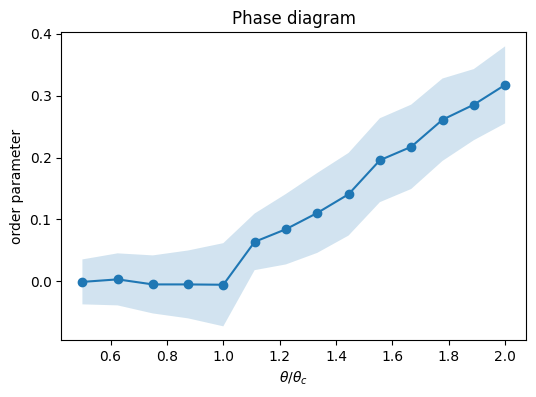

In [24]:
# Aggregate across runs for each theta and plot the order parameter.
repo_root = find_repo_root()
phase_diagram_base_folder = repo_root / "results/phase_diagram/power_law/n1000"

run_dirs = list_phase_diagram_runs(phase_diagram_base_folder)
# Compute theta_c from the first config_used.json (theta itself is ignored).
theta_c = compute_theta_c_from_config(run_dirs[0] / "config_used.json")
config = read_config(run_dirs[0] / "config_used.json")
phase_df = build_phase_diagram(
    phase_diagram_base_folder,
    frac=0.7,
    theta_c=theta_c,
)
phase_df["theta_scaled"] = phase_df["theta"] / theta_c
phase_df["std"] = np.sqrt(phase_df["var_x1"])

fig, ax = plt.subplots(figsize=(6, 4))
phase_df.plot(x="theta_scaled", y="mean_x1", marker="o", ax=ax, legend=False)
ax.fill_between(
    phase_df["theta_scaled"],
    phase_df["mean_x1"] - phase_df["std"],
    phase_df["mean_x1"] + phase_df["std"],
    alpha=0.2,
)
ax.set_xlabel(r"$\theta/\theta_c$")
ax.set_ylabel("order parameter")
ax.set_title("Phase diagram")

# Inspect one run's time series
# mean_df, std_df = read_aggregate_dfs(run_dirs[11] / "aggregate.h5")
# mean_df.plot(x="t", y="mean_x1_abs")


## Response Experiments Analysis
Analyse aggregated response results (mean/std over time for +/- epsilon).


In [2]:
from pathlib import Path
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Point this to the run/job folder that contains aggregate.h5
repo_root = find_repo_root()

path_aggregate_files = [f'results/linear_response/poisson/critical/n{N}/perturbed_runs/' for N in [1000,5000,'10_000']]
records = {
    'meta_data' : [],
    'df_plus' : [],
    'df_minus' : [],
    'df_response': [],
    'df_quad': [],
    'N' : [1000,5000,10000]
}
for path_aggregate_file in path_aggregate_files:
    agg_path = repo_root / path_aggregate_file /  'merged_response.h5'

    with h5py.File(agg_path, 'r') as fh:
        fieldnames = [s.decode('utf-8') for s in np.asarray(fh.attrs['fieldnames']).tolist()]
        mean_plus = np.asarray(fh['mean_plus'][...])
        mean_minus = np.asarray(fh['mean_minus'][...])
        graph_count = int(fh.attrs.get('graph_count', 0))
        sample_count = int(fh.attrs.get('sample_count', 0))
        meta_data = dict(fh.attrs)

        df_plus = pd.DataFrame(mean_plus, columns=fieldnames)
        df_minus = pd.DataFrame(mean_minus, columns=fieldnames)
        df_response = ( df_plus - df_minus ) / ( float( 2* meta_data["perturbation_epsilon"] ) )

        df_response['t'] = df_plus['t']

        df_quad = ( df_plus  + df_minus ) / ( 2 * meta_data["perturbation_epsilon"]**2 )
        df_quad['t'] = df_response['t'] 

        records['meta_data'].append(meta_data)
        records['df_minus'].append(df_minus)
        records['df_plus'].append(df_plus)
        records["df_response"].append(df_response)
        records["df_quad"].append(df_quad)

(-10.0, 500.0)

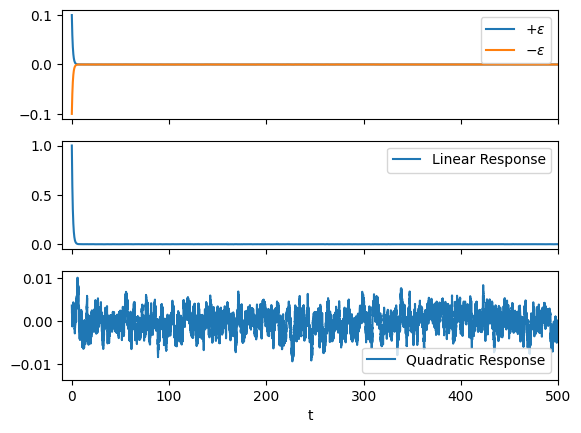

In [ ]:
fig, ax = plt.subplots(nrows=3,sharex=True)
df_plus.plot(x="t",y="mean_x1",label=r"$+ \varepsilon$",ax=ax[0])
df_minus.plot(x="t",y="mean_x1",label=r"$- \varepsilon$",ax=ax[0])
df_response.plot(x="t",y="mean_x1",label="Linear Response",ax=ax[1])
df_quad.plot(x='t',y= 'mean_x1',label="Quadratic Response",ax=ax[2])

ax[-1].set_xlim(-10,500)

In [4]:
path_aggregate_files = 'results/linear_response/poisson/far/n1000/perturbed_runs/' 
agg_path = repo_root / path_aggregate_file /  'merged_response.h5'

with h5py.File(agg_path, 'r') as fh:
    fieldnames = [s.decode('utf-8') for s in np.asarray(fh.attrs['fieldnames']).tolist()]
    mean_plus = np.asarray(fh['mean_plus'][...])
    mean_minus = np.asarray(fh['mean_minus'][...])
    graph_count = int(fh.attrs.get('graph_count', 0))
    sample_count = int(fh.attrs.get('sample_count', 0))
    meta_data = dict(fh.attrs)

    df_plus = pd.DataFrame(mean_plus, columns=fieldnames)
    df_minus = pd.DataFrame(mean_minus, columns=fieldnames)
    df_response = ( df_plus - df_minus ) / ( float( 2* meta_data["perturbation_epsilon"] ) )

    df_response['t'] = df_plus['t']

    df_quad = ( df_plus  + df_minus ) / ( 2 * meta_data["perturbation_epsilon"]**2 )
    df_quad['t'] = df_response['t'] 

(-10.0, 1000.0)

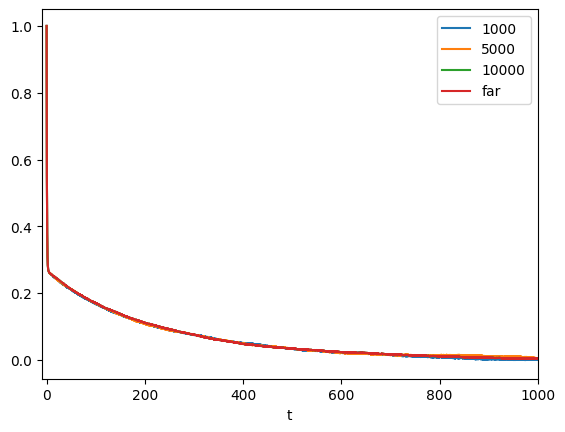

In [5]:
fig, ax = plt.subplots()
for i in range(3):
    records["df_response"][i].plot(x='t',y='mean_x1',ax=ax,label=records["N"][i])

df_response.plot(x='t',y='mean_x1',ax=ax,label="far")
ax.set_xlim(-10,1000)



(-10.0, 1500.0)

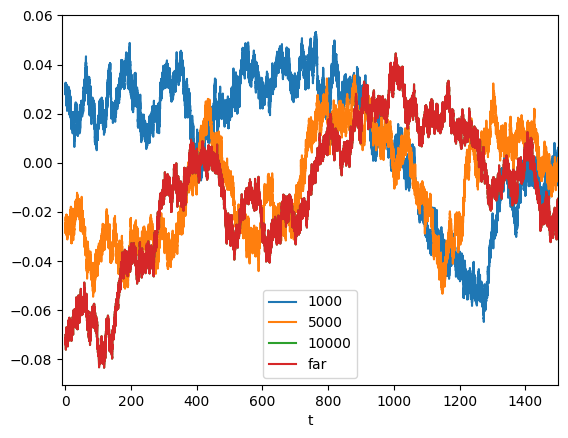

In [7]:
fig, ax = plt.subplots()
for i in range(3):
    records["df_quad"][i].plot(x='t',y='mean_x1',ax=ax,label=records["N"][i])

df_quad.plot(x='t',y='mean_x1',ax=ax,label="far")
ax.set_xlim(-10,1500)

